In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [117]:
df = pd.read_csv('/content/sample_data/Churn_Modelling.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [118]:
print("Dataset size: ",df.size)
print("Shape(rows,cols): ",df.shape)

Dataset size:  140000
Shape(rows,cols):  (10000, 14)


In [119]:
df.isnull().sum()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [120]:
df.dtypes

,0
RowNumber,int64
CustomerId,int64
Surname,object
CreditScore,int64
Geography,object
Gender,object
Age,int64
Tenure,int64
Balance,float64
NumOfProducts,int64


In [121]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [122]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [123]:
df.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)

In [124]:
print(df)

      CreditScore Geography  Gender  ...  IsActiveMember  EstimatedSalary  Exited
0             619    France  Female  ...               1        101348.88       1
1             608     Spain  Female  ...               1        112542.58       0
2             502    France  Female  ...               0        113931.57       1
3             699    France  Female  ...               0         93826.63       0
4             850     Spain  Female  ...               1         79084.10       0
...           ...       ...     ...  ...             ...              ...     ...
9995          771    France    Male  ...               0         96270.64       0
9996          516    France    Male  ...               1        101699.77       0
9997          709    France  Female  ...               1         42085.58       1
9998          772   Germany    Male  ...               0         92888.52       1
9999          792    France  Female  ...               0         38190.78       0

[10000 rows x 1

In [125]:
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'BalancePerProduct']
categorical_features = ['Geography', 'Gender']

In [126]:
# Balance per product
df["Balance_per_Product"] = df["Balance"] / (df["NumOfProducts"] + 1e-9)

# Group/Bin ages
df["Age_group"] = pd.cut(df["Age"], bins=[17, 30, 45, 60, 120], labels=["18-30", "31-45", "46-60", "60+"])

In [127]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_per_Product,Age_group
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000,31-45
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,83807.859916,31-45
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,53220.266649,31-45
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.000000,31-45
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,125510.819874,31-45
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0,0.000000,31-45
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,57369.609943,31-45
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1,0.000000,31-45
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,37537.654981,31-45


In [128]:
target = 'Exited'
cat_cols = ['Geography','Gender','Age_group']
num_cols = []

for c in df.columns:
  if c not in cat_cols + [target]:
    num_cols.append(c)

print('Categorical: ',cat_cols)
print('Numerical: ',num_cols)

Categorical:  ['Geography', 'Gender', 'Age_group']
Numerical:  ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Balance_per_Product']


In [129]:
x = df.drop(columns = [target])
y = df[target]

X_train,X_test,Y_train,Y_test = train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)

In [130]:
preprocessor = ColumnTransformer([
    ("num",StandardScaler(),num_cols),
    ("cat",OneHotEncoder(handle_unknown='ignore',drop='first'),cat_cols)
])

X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.fit_transform(X_test)
# It will be directly used by SMOTE along with X_train_p

# Smote used to prevent bias/ overfitting in dataset by sampling

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_p,Y_train)

In [131]:
models = {
    "logistic": LogisticRegression(max_iter=1000,class_weight="balanced",random_state=42),
    "random_forest": RandomForestClassifier(n_estimators=200,class_weight="balanced",n_jobs=-1,random_state=42),
    "xgboost" : XGBClassifier(use_label_encoder=False,eval_metric="logloss",nestimators=200,random_state=42)
}

In [140]:
results = {}

for name,model in models.items():
  model.fit(X_train_res,y_train_res)
  y_pred = model.predict(X_test_p)

  try:
    y_prob = model.predict_proba(X_test_p)[:,1]
  except:
    y_prob = model.predict_proba(X_test_p)

  auc = roc_auc_score(Y_test, y_prob)
  precision = precision_score(Y_test, y_pred, zero_division=0)
  recall = recall_score(Y_test, y_pred, zero_division=0)
  f1 = f1_score(Y_test, y_pred, zero_division=0)
  cm = confusion_matrix(Y_test, y_pred)
  report = classification_report(Y_test,y_pred,zero_division=0)

  results[name] = {
      "model":model,
      "auc":auc,
      "precision":precision,
      "recall":recall,
      "f1":f1,
      "confusion_matrix":cm,
      "report":report
  }


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:10:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "nestimators", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [141]:
import os

os.makedirs("outputs", exist_ok=True)
summary_lines = []
for name, r in results.items():
    line = f"{name}: AUC={r['auc']:.4f}, Precision={r['precision']:.4f}, Recall={r['recall']:.4f}, F1={r['f1']:.4f}"
    summary_lines.append(line)
    print(line)
    print(r["report"])
    print("confusion_matrix")
    print(r["confusion_matrix"])
    joblib.dump({
        "preprocessor": preprocessor,
        "model": r["model"]
    }, f"outputs/{name}_pipeline.joblib")

logistic: AUC=0.7889, Precision=0.4119, Recall=0.6830, F1=0.5139
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1593
           1       0.41      0.68      0.51       407

    accuracy                           0.74      2000
   macro avg       0.66      0.72      0.67      2000
weighted avg       0.80      0.74      0.76      2000

confusion_matrix
[[1196  397]
 [ 129  278]]
random_forest: AUC=0.8458, Precision=0.6051, Recall=0.5872, F1=0.5960
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1593
           1       0.61      0.59      0.60       407

    accuracy                           0.84      2000
   macro avg       0.75      0.74      0.75      2000
weighted avg       0.84      0.84      0.84      2000

confusion_matrix
[[1437  156]
 [ 168  239]]
xgboost: AUC=0.7107, Precision=0.2636, Recall=0.8206, F1=0.3990
              precision    recall  f1-score   support

    

--- Model Evaluation Visualizations ---


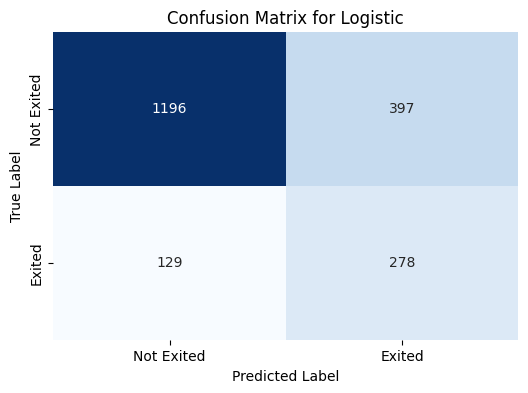

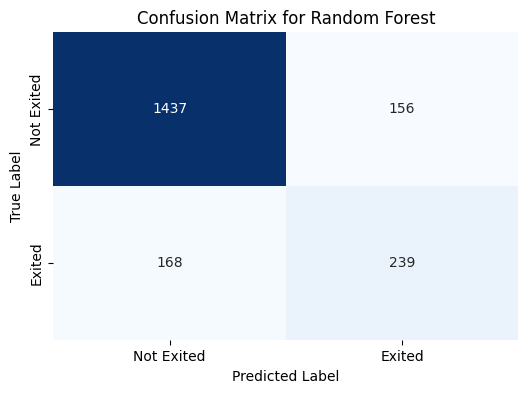

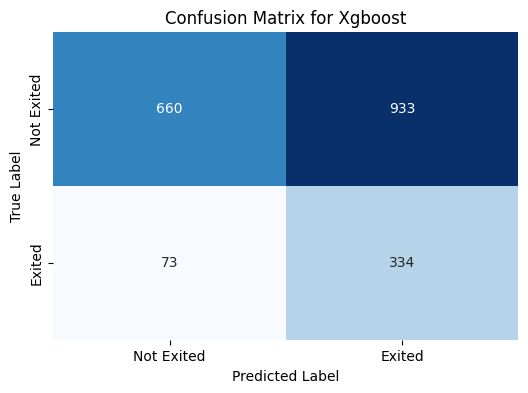

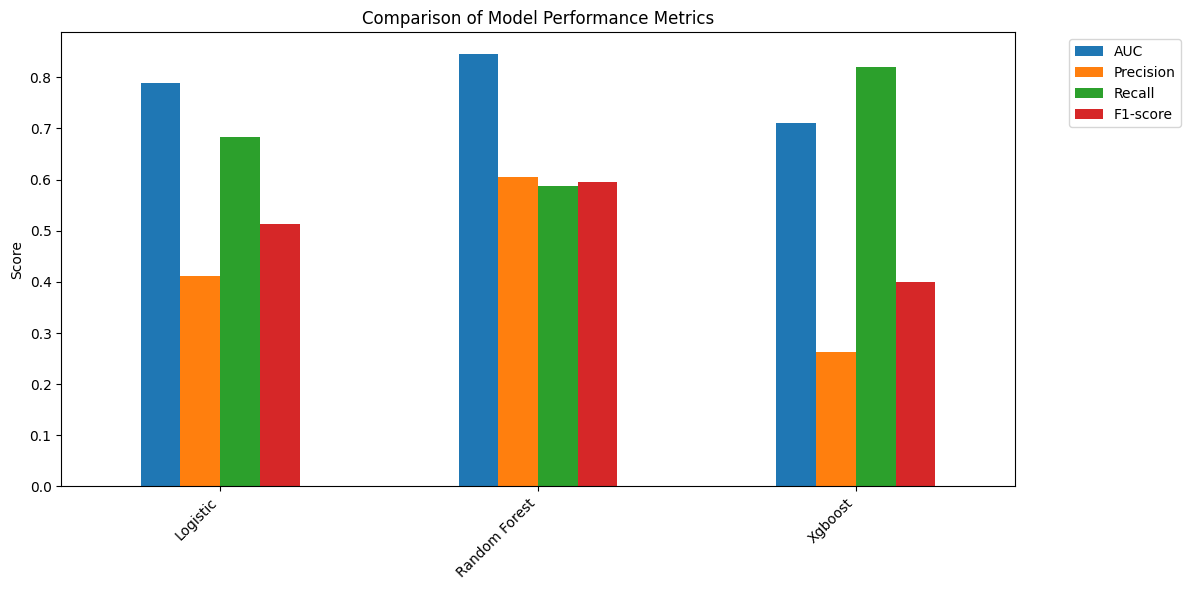


The best performing model based on F1-score is: Random Forest with F1-score: 0.5960


In [146]:
print('--- Model Evaluation Visualizations ---')

for name, r in results.items():
    plt.figure(figsize=(6, 4))
    sns.heatmap(r['confusion_matrix'], annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
    plt.title(f'Confusion Matrix for {name.replace("_", " ").title()}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

metric_names = ['AUC', 'Precision', 'Recall', 'F1-score']
metrics_data = {metric: [] for metric in metric_names}
model_names = []

for name, r in results.items():
    model_names.append(name.replace("_", " ").title())
    metrics_data['AUC'].append(r['auc'])
    metrics_data['Precision'].append(r['precision'])
    metrics_data['Recall'].append(r['recall'])
    metrics_data['F1-score'].append(r['f1'])

metrics_df = pd.DataFrame(metrics_data, index=model_names)

metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

best_model_name = None
best_f1 = -1
for name, r in results.items():
    if r['f1'] > best_f1:
        best_f1 = r['f1']
        best_model_name = name

print(f"\nThe best performing model based on F1-score is: {best_model_name.replace('_', ' ').title()} with F1-score: {best_f1:.4f}")